In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer

#Load in the resampled dataset
df = pd.read_csv('../data/processed/hourly_pollutionpatterns.csv').set_index('DATETIME')

# Including harmonic signals
def sin_encoder(period):
        return FunctionTransformer(lambda x: np.sin((2 * np.pi* x)/period))

def cos_encoder(period):

    return FunctionTransformer(lambda x: np.cos((2 * np.pi* x)/period))

def adding_remaining_features(df):

    df.index = pd.to_datetime(df.index, utc=True)

    pollutants = ["TOC", "TN", "TP", "SS"]

    df["sine"] = sin_encoder(24).fit_transform(df.index.hour)
    df["cosine"] = cos_encoder(24).fit_transform(df.index.hour)

    # Including day of week
    df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

    # Taking the logarithm of Pollutants
    logcn = lambda x: f"log{x}"
    logpollutants = []
    for p in pollutants:
        cn = logcn(p)
        df[cn] = np.log(1 + df[p].divide(df[p].max()))
        logpollutants.append(cn)

    return df
  
#Use the function
df_chunks = adding_remaining_features(df)

In [2]:
df_chunks

,TOC,TN,TP,SS,Flow,Bypass,Rain,sine,cosine,is_weekend,logTOC,logTN,logTP,logSS
DATETIME,,,,,,,,,,,,,,
2020-12-31 23:00:00+00:00,74.554167,29.367552,3.219927,3.713267,1005.133333,0.000007,0.0,-2.588190e-01,0.965926,0,0.071914,0.080307,0.044925,0.301936
2021-01-01 00:00:00+00:00,68.239583,24.129583,2.863656,4.088235,1012.933333,0.000006,0.0,0.000000e+00,1.000000,0,0.066020,0.066448,0.040052,0.327913
2021-01-01 01:00:00+00:00,68.305208,24.448594,2.767479,4.575304,962.500000,0.000014,0.0,2.588190e-01,0.965926,0,0.066081,0.067297,0.038733,0.360678
2021-01-01 02:00:00+00:00,60.715625,25.982396,3.202427,4.691871,927.883333,0.000011,0.0,5.000000e-01,0.866025,0,0.058951,0.071372,0.044686,0.368363
2021-01-01 03:00:00+00:00,62.157292,24.284167,3.012552,5.011011,933.033333,0.000013,0.0,7.071068e-01,0.707107,0,0.060309,0.066859,0.042091,0.389106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 12:00:00+00:00,75.990625,23.000104,6.763969,0.154584,1111.300000,0.000002,0.0,1.224647e-16,-1.000000,0,0.073250,0.063434,0.092144,0.014567
2024-02-20 13:00:00+00:00,71.097917,20.706875,6.111146,0.192213,1160.050000,0.000004,0.0,-2.588190e-01,-0.965926,0,0.068692,0.057287,0.083612,0.018081
2024-02-20 14:00:00+00:00,99.451042,24.020208,4.948927,0.214480,1228.900000,0.000004,0.0,-5.000000e-01,-0.866025,0,0.094822,0.066156,0.068240,0.020155


In [3]:
#The function
def dataProcessing_Chunks(inputdf,features,hours_ahead,hours_behind):
    df_copy = inputdf.copy()
    for feature in features:
        for i in range(1,hours_ahead+1,1):
            df_copy[f'{feature}+{i}'] = df_copy[f'{feature}'].shift(-i)
    for feature in features:
        for i in range(1,hours_behind+1,1):
            df_copy[f'{feature}-{i}'] = df_copy[f'{feature}'].shift(i)   
    df_copy.dropna(inplace=True)
    return df_copy

In [4]:
#Make a df holding the orginal values
fetures_shift = ["TOC", "TN", "TP", "SS"]
df_origval = dataProcessing_Chunks(df_chunks,fetures_shift,6,6)
df_origval = dataProcessing_Chunks(df_origval,["Rain"],6,0)

In [5]:
df_origval

,TOC,TN,TP,SS,Flow,Bypass,Rain,sine,cosine,is_weekend,...,SS-3,SS-4,SS-5,SS-6,Rain+1,Rain+2,Rain+3,Rain+4,Rain+5,Rain+6
DATETIME,,,,,,,,,,,,,,,,,,,,,
2021-01-01 05:00:00+00:00,74.140625,27.367812,3.725312,5.595631,830.066667,0.000008,0.0,0.965926,2.588190e-01,0,...,4.691871,4.575304,4.088235,3.713267,0.1,0.3,0.3,0.0,0.1,0.3
2021-01-01 06:00:00+00:00,65.923958,26.089219,3.375896,4.491904,793.966667,0.000004,0.1,1.000000,6.123234e-17,0,...,5.011011,4.691871,4.575304,4.088235,0.3,0.3,0.0,0.1,0.3,0.1
2021-01-01 07:00:00+00:00,63.631250,24.883906,3.672448,4.919996,866.266667,0.000008,0.3,0.965926,-2.588190e-01,0,...,5.359723,5.011011,4.691871,4.575304,0.3,0.0,0.1,0.3,0.1,0.0
2021-01-01 08:00:00+00:00,68.146875,23.861979,3.462083,5.175239,1016.950000,0.000009,0.3,0.866025,-5.000000e-01,0,...,5.595631,5.359723,5.011011,4.691871,0.0,0.1,0.3,0.1,0.0,0.0
2021-01-01 09:00:00+00:00,75.268750,23.759896,3.970458,5.554139,1067.333333,0.000000,0.0,0.707107,-7.071068e-01,0,...,4.491904,5.595631,5.359723,5.011011,0.1,0.3,0.1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 00:00:00+00:00,52.902083,15.408021,0.978396,0.122292,1240.166667,0.000003,0.0,0.000000,1.000000e+00,0,...,0.147065,0.150766,0.150900,0.159901,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-20 01:00:00+00:00,49.113542,15.526146,1.500333,0.103813,991.300000,0.000004,0.0,0.258819,9.659258e-01,0,...,0.164105,0.147065,0.150766,0.150900,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-20 02:00:00+00:00,41.825000,13.883333,0.980802,0.086143,964.850000,0.000002,0.0,0.500000,8.660254e-01,0,...,0.171329,0.164105,0.147065,0.150766,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_origval.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'Rain', 'sine', 'cosine',
       'is_weekend', 'logTOC', 'logTN', 'logTP', 'logSS', 'TOC+1', 'TOC+2',
       'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2', 'TN+3', 'TN+4',
       'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5', 'TP+6', 'SS+1',
       'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6', 'TOC-1', 'TOC-2', 'TOC-3',
       'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4', 'TN-5',
       'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1', 'SS-2',
       'SS-3', 'SS-4', 'SS-5', 'SS-6', 'Rain+1', 'Rain+2', 'Rain+3', 'Rain+4',
       'Rain+5', 'Rain+6'],
      dtype='object')

In [7]:
#make a df with the log values
df_logs = df_chunks.drop(["TOC", "TN", "TP", "SS"],axis=1)
fetures_shift = ["logTOC", "logTN", "logTP", "logSS"]
df_logs = dataProcessing_Chunks(df_logs,fetures_shift,6,6)
df_logs = dataProcessing_Chunks(df_logs,["Rain"],6,0)
df_logs = df_logs.drop(["Rain"],axis=1)

In [8]:
df_logs

,Flow,Bypass,sine,cosine,is_weekend,logTOC,logTN,logTP,logSS,logTOC+1,...,logSS-3,logSS-4,logSS-5,logSS-6,Rain+1,Rain+2,Rain+3,Rain+4,Rain+5,Rain+6
DATETIME,,,,,,,,,,,,,,,,,,,,,
2021-01-01 05:00:00+00:00,830.066667,0.000008,0.965926,2.588190e-01,0,0.071529,0.075038,0.051796,0.426022,0.063849,...,0.368363,0.360678,0.327913,0.301936,0.1,0.3,0.3,0.0,0.1,0.3
2021-01-01 06:00:00+00:00,793.966667,0.000004,1.000000,6.123234e-17,0,0.063849,0.071655,0.047050,0.355143,0.061696,...,0.389106,0.368363,0.360678,0.327913,0.3,0.3,0.0,0.1,0.3,0.1
2021-01-01 07:00:00+00:00,866.266667,0.000008,0.965926,-2.588190e-01,0,0.061696,0.068455,0.051079,0.383234,0.065933,...,0.411289,0.389106,0.368363,0.360678,0.3,0.0,0.1,0.3,0.1,0.0
2021-01-01 08:00:00+00:00,1016.950000,0.000009,0.866025,-5.000000e-01,0,0.065933,0.065734,0.048223,0.399614,0.072579,...,0.426022,0.411289,0.389106,0.368363,0.0,0.1,0.3,0.1,0.0,0.0
2021-01-01 09:00:00+00:00,1067.333333,0.000000,0.707107,-7.071068e-01,0,0.072579,0.065462,0.055112,0.423446,0.062604,...,0.355143,0.426022,0.411289,0.389106,0.1,0.3,0.1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 00:00:00+00:00,1240.166667,0.000003,0.000000,1.000000e+00,0,0.051556,0.042937,0.013865,0.011541,0.047951,...,0.013863,0.014210,0.014222,0.015064,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-20 01:00:00+00:00,991.300000,0.000004,0.258819,9.659258e-01,0,0.047951,0.043259,0.021184,0.009806,0.040979,...,0.015457,0.013863,0.014210,0.014222,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-20 02:00:00+00:00,964.850000,0.000002,0.500000,8.660254e-01,0,0.040979,0.038769,0.013899,0.008144,0.038558,...,0.016132,0.015457,0.013863,0.014210,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_logs.columns

Index(['Flow', 'Bypass', 'sine', 'cosine', 'is_weekend', 'logTOC', 'logTN',
       'logTP', 'logSS', 'logTOC+1', 'logTOC+2', 'logTOC+3', 'logTOC+4',
       'logTOC+5', 'logTOC+6', 'logTN+1', 'logTN+2', 'logTN+3', 'logTN+4',
       'logTN+5', 'logTN+6', 'logTP+1', 'logTP+2', 'logTP+3', 'logTP+4',
       'logTP+5', 'logTP+6', 'logSS+1', 'logSS+2', 'logSS+3', 'logSS+4',
       'logSS+5', 'logSS+6', 'logTOC-1', 'logTOC-2', 'logTOC-3', 'logTOC-4',
       'logTOC-5', 'logTOC-6', 'logTN-1', 'logTN-2', 'logTN-3', 'logTN-4',
       'logTN-5', 'logTN-6', 'logTP-1', 'logTP-2', 'logTP-3', 'logTP-4',
       'logTP-5', 'logTP-6', 'logSS-1', 'logSS-2', 'logSS-3', 'logSS-4',
       'logSS-5', 'logSS-6', 'Rain+1', 'Rain+2', 'Rain+3', 'Rain+4', 'Rain+5',
       'Rain+6'],
      dtype='object')

In [10]:
def split_dataset(inputdf,features_drop,hours_ahead):
    holder = []
    for feature in features_drop:
        for i in range(1,hours_ahead+1,1):
            holder.append(f'{feature}+{i}')
    X1 = inputdf.drop(holder, axis=1)
    y1 = inputdf[holder]
    return X1, y1

In [11]:
#Split the original
fetures_drop = ['TOC','TN','TP','SS']
Xo, yo = split_dataset(df_origval,fetures_drop,6)

In [12]:
Xo.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'Rain', 'sine', 'cosine',
       'is_weekend', 'logTOC', 'logTN', 'logTP', 'logSS', 'TOC-1', 'TOC-2',
       'TOC-3', 'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4',
       'TN-5', 'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1',
       'SS-2', 'SS-3', 'SS-4', 'SS-5', 'SS-6', 'Rain+1', 'Rain+2', 'Rain+3',
       'Rain+4', 'Rain+5', 'Rain+6'],
      dtype='object')

In [13]:
yo.columns

Index(['TOC+1', 'TOC+2', 'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2',
       'TN+3', 'TN+4', 'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5',
       'TP+6', 'SS+1', 'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6'],
      dtype='object')

In [14]:
#Split the logdata set
fetures_drop = ["logTOC", "logTN", "logTP", "logSS"]
Xl, yl = split_dataset(df_logs,fetures_drop,6)

In [15]:
Xl.columns

Index(['Flow', 'Bypass', 'sine', 'cosine', 'is_weekend', 'logTOC', 'logTN',
       'logTP', 'logSS', 'logTOC-1', 'logTOC-2', 'logTOC-3', 'logTOC-4',
       'logTOC-5', 'logTOC-6', 'logTN-1', 'logTN-2', 'logTN-3', 'logTN-4',
       'logTN-5', 'logTN-6', 'logTP-1', 'logTP-2', 'logTP-3', 'logTP-4',
       'logTP-5', 'logTP-6', 'logSS-1', 'logSS-2', 'logSS-3', 'logSS-4',
       'logSS-5', 'logSS-6', 'Rain+1', 'Rain+2', 'Rain+3', 'Rain+4', 'Rain+5',
       'Rain+6'],
      dtype='object')

In [16]:
yl.columns

Index(['logTOC+1', 'logTOC+2', 'logTOC+3', 'logTOC+4', 'logTOC+5', 'logTOC+6',
       'logTN+1', 'logTN+2', 'logTN+3', 'logTN+4', 'logTN+5', 'logTN+6',
       'logTP+1', 'logTP+2', 'logTP+3', 'logTP+4', 'logTP+5', 'logTP+6',
       'logSS+1', 'logSS+2', 'logSS+3', 'logSS+4', 'logSS+5', 'logSS+6'],
      dtype='object')

In [17]:
X_train = Xl[:20000]
X_test = Xl[20000:26683]
y_train = yl[:20000]
y_test = yl[20000:26683]

In [18]:
X_train.columns

Index(['Flow', 'Bypass', 'sine', 'cosine', 'is_weekend', 'logTOC', 'logTN',
       'logTP', 'logSS', 'logTOC-1', 'logTOC-2', 'logTOC-3', 'logTOC-4',
       'logTOC-5', 'logTOC-6', 'logTN-1', 'logTN-2', 'logTN-3', 'logTN-4',
       'logTN-5', 'logTN-6', 'logTP-1', 'logTP-2', 'logTP-3', 'logTP-4',
       'logTP-5', 'logTP-6', 'logSS-1', 'logSS-2', 'logSS-3', 'logSS-4',
       'logSS-5', 'logSS-6', 'Rain+1', 'Rain+2', 'Rain+3', 'Rain+4', 'Rain+5',
       'Rain+6'],
      dtype='object')

In [19]:
y_train.columns

Index(['logTOC+1', 'logTOC+2', 'logTOC+3', 'logTOC+4', 'logTOC+5', 'logTOC+6',
       'logTN+1', 'logTN+2', 'logTN+3', 'logTN+4', 'logTN+5', 'logTN+6',
       'logTP+1', 'logTP+2', 'logTP+3', 'logTP+4', 'logTP+5', 'logTP+6',
       'logSS+1', 'logSS+2', 'logSS+3', 'logSS+4', 'logSS+5', 'logSS+6'],
      dtype='object')

In [20]:
X_test

,Flow,Bypass,sine,cosine,is_weekend,logTOC,logTN,logTP,logSS,logTOC-1,...,logSS-3,logSS-4,logSS-5,logSS-6,Rain+1,Rain+2,Rain+3,Rain+4,Rain+5,Rain+6
DATETIME,,,,,,,,,,,,,,,,,,,,,
2023-05-17 09:00:00+00:00,790.783333,761.550000,7.071068e-01,-0.707107,0,0.161223,0.111913,0.112715,0.134434,0.165768,...,0.212556,0.227276,0.234156,0.235689,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-17 10:00:00+00:00,1035.033333,919.600000,5.000000e-01,-0.866025,0,0.168500,0.125815,0.146309,0.114314,0.161223,...,0.177213,0.212556,0.227276,0.234156,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-17 11:00:00+00:00,760.666667,843.366667,2.588190e-01,-0.965926,0,0.174227,0.121019,0.191677,0.103321,0.168500,...,0.144659,0.177213,0.212556,0.227276,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-17 12:00:00+00:00,732.500000,477.216667,1.224647e-16,-1.000000,0,0.172010,0.121426,0.201407,0.054926,0.174227,...,0.134434,0.144659,0.177213,0.212556,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-17 13:00:00+00:00,699.450000,0.000000,-2.588190e-01,-0.965926,0,0.131171,0.103597,0.130626,0.038801,0.172010,...,0.114314,0.134434,0.144659,0.177213,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 00:00:00+00:00,1240.166667,0.000003,0.000000e+00,1.000000,0,0.051556,0.042937,0.013865,0.011541,0.059913,...,0.013863,0.014210,0.014222,0.015064,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-20 01:00:00+00:00,991.300000,0.000004,2.588190e-01,0.965926,0,0.047951,0.043259,0.021184,0.009806,0.051556,...,0.015457,0.013863,0.014210,0.014222,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-20 02:00:00+00:00,964.850000,0.000002,5.000000e-01,0.866025,0,0.040979,0.038769,0.013899,0.008144,0.047951,...,0.016132,0.015457,0.013863,0.014210,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# import xgboost as xgb

# # Create the XGBoost model
# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# # Train the XGBoost model
# xgb_model.fit(X_train, y_train)

In [22]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid={"random_state": [42],
            "learning_rate": (0.05, 0.10, 0.15),
            "max_depth": [ 3, 4, 5, 6, 8],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2],
            "colsample_bytree":[ 0.3, 0.4],
            'n_estimators': [100,200]}

grid_search = GridSearchCV(xgb.XGBRegressor(),param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=True, n_jobs=-1) 
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': (0.05, 0.1, 0.15),
                         'max_depth': [3, 4, 5, 6, 8],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': [100, 200], 'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [23]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score",ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
363,51.484439,4.088169,1.330119,0.121128,0.4,0.0,0.05,3,3,200,42,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",-0.068941,-0.032918,-0.030269,-0.044043,0.017639,1
365,45.431718,1.427595,1.500712,0.070056,0.4,0.0,0.05,3,5,200,42,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",-0.069075,-0.032926,-0.030297,-0.044100,0.017693,2
361,50.344074,7.249098,1.310604,0.110125,0.4,0.0,0.05,3,1,200,42,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",-0.069094,-0.032934,-0.030323,-0.044117,0.017694,3
367,45.134610,1.740049,1.594964,0.143590,0.4,0.0,0.05,3,7,200,42,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",-0.069207,-0.032909,-0.030259,-0.044125,0.017769,4
402,28.859601,2.509879,0.900510,0.050529,0.4,0.0,0.1,3,3,100,42,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",-0.069122,-0.032976,-0.030381,-0.044160,0.017683,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,344.885592,24.439003,9.396793,2.137732,0.3,0.0,0.15,8,3,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-0.074691,-0.037360,-0.031996,-0.048016,0.018989,716
472,189.176070,4.648160,3.177702,0.193669,0.4,0.0,0.15,8,1,100,42,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",-0.075779,-0.036819,-0.031453,-0.048017,0.019753,717
473,416.966886,24.897866,8.929472,2.555708,0.4,0.0,0.15,8,1,200,42,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",-0.075812,-0.037135,-0.031661,-0.048203,0.019650,718
112,210.213977,8.273097,4.576771,1.102482,0.3,0.0,0.15,8,1,100,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-0.075870,-0.037280,-0.031797,-0.048316,0.019612,719


In [24]:
grid_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 200,
 'random_state': 42}

In [25]:
final_model = grid_search.best_estimator_

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

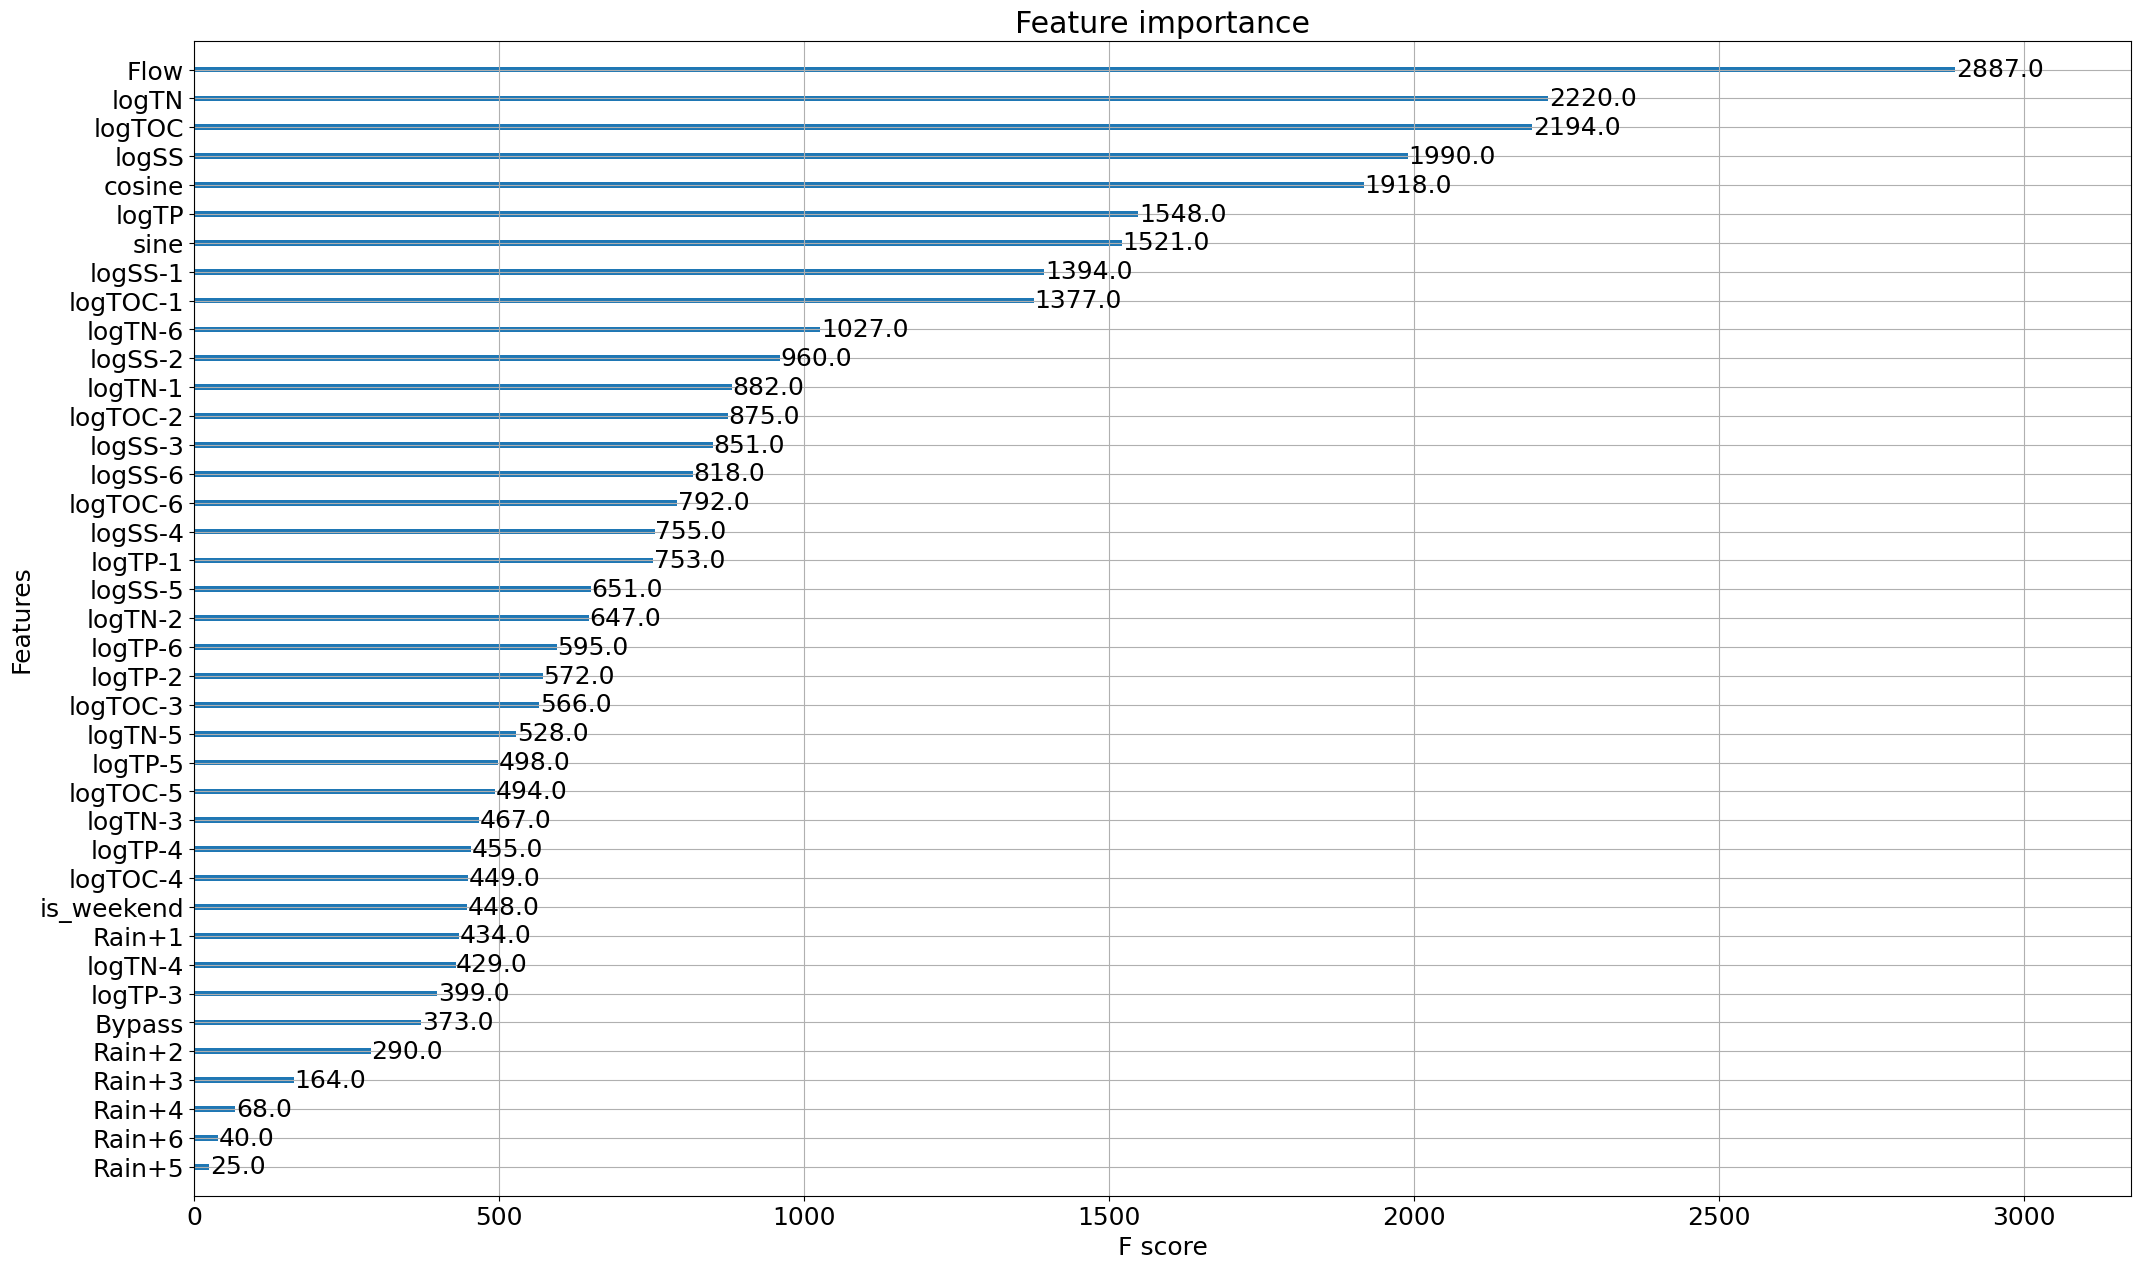

In [59]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25, 15)
xgb.plot_importance(final_model)


In [60]:
xgb_y_pred = final_model.predict(X_test)

In [61]:
dfxgb_y_pred = pd.DataFrame(xgb_y_pred, columns=yo.columns)
dfxgb_y_pred

,TOC+1,TOC+2,TOC+3,TOC+4,TOC+5,TOC+6,TN+1,TN+2,TN+3,TN+4,...,TP+3,TP+4,TP+5,TP+6,SS+1,SS+2,SS+3,SS+4,SS+5,SS+6
0,0.148961,0.149707,0.143262,0.147698,0.138618,0.140856,0.109525,0.108525,0.104250,0.108287,...,0.117266,0.112969,0.113385,0.107025,0.129402,0.120990,0.114912,0.117126,0.104785,0.103806
1,0.158287,0.145023,0.147138,0.139880,0.140881,0.132962,0.118376,0.106097,0.098718,0.102594,...,0.121997,0.120169,0.113416,0.114909,0.118682,0.113091,0.112359,0.111773,0.098431,0.103011
2,0.165590,0.155537,0.154078,0.152493,0.146043,0.143558,0.120237,0.116436,0.113185,0.111766,...,0.147452,0.142153,0.142986,0.138611,0.103156,0.107288,0.114804,0.113745,0.114471,0.104392
3,0.163800,0.158893,0.153882,0.151105,0.148693,0.142840,0.120103,0.115784,0.111285,0.107919,...,0.148347,0.141342,0.137184,0.132630,0.075602,0.087164,0.090448,0.082791,0.089489,0.084237
4,0.130746,0.140965,0.144582,0.147490,0.143929,0.140487,0.104488,0.103944,0.105240,0.100080,...,0.124996,0.119040,0.111210,0.110684,0.053575,0.066349,0.065805,0.060951,0.061291,0.062314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6672,0.049494,0.046009,0.041220,0.037614,0.038797,0.040937,0.040167,0.037193,0.035109,0.035513,...,0.009245,0.004768,0.004361,0.004401,0.012982,0.010808,0.011158,0.010802,0.011950,0.011127
6673,0.045944,0.045198,0.043139,0.047049,0.048369,0.050675,0.042909,0.042026,0.042498,0.042287,...,0.016450,0.013906,0.015158,0.015990,0.012185,0.012203,0.011926,0.013895,0.015226,0.017537
6674,0.044222,0.042923,0.042517,0.047457,0.047649,0.052861,0.040728,0.041847,0.041953,0.041419,...,0.017151,0.012306,0.016289,0.018733,0.011537,0.012367,0.012859,0.012973,0.016565,0.021322
6675,0.035205,0.041834,0.042549,0.048179,0.050896,0.060048,0.036508,0.036033,0.039916,0.039720,...,0.017864,0.022584,0.025920,0.027303,0.011602,0.012878,0.013571,0.017325,0.020384,0.024075


In [62]:
pollutants = ["TOC", "TN", "TP", "SS"]
for p in yo.columns:
    if "TOC" in p:
        dfxgb_y_pred[p] = dfxgb_y_pred[p].apply(lambda x: (np.exp(x)-1) * df['TOC'].max())
    if "TN" in p:
        dfxgb_y_pred[p] = dfxgb_y_pred[p].apply(lambda x: (np.exp(x)-1) * df['TN'].max())
    if "TP" in p:
        dfxgb_y_pred[p] = dfxgb_y_pred[p].apply(lambda x: (np.exp(x)-1) * df['TP'].max())
    if "SS" in p:
        dfxgb_y_pred[p] = dfxgb_y_pred[p].apply(lambda x: (np.exp(x)-1) * df['SS'].max())
        

In [63]:
dfxgb_y_pred

,TOC+1,TOC+2,TOC+3,TOC+4,TOC+5,TOC+6,TN+1,TN+2,TN+3,TN+4,...,TP+3,TP+4,TP+5,TP+6,SS+1,SS+2,SS+3,SS+4,SS+5,SS+6
0,160.608024,161.474587,154.014078,159.143589,148.666919,151.240630,40.651164,40.259727,38.589829,40.166654,...,8.718823,8.380948,8.413541,7.915938,1.455363,1.354921,1.282878,1.309069,1.163803,1.152359
1,171.482386,156.047244,158.494596,150.117294,151.269499,142.190124,44.135089,39.310233,36.439331,37.944859,...,9.092421,8.947833,8.416036,8.533284,1.327517,1.261379,1.252748,1.245837,1.089709,1.143066
2,180.067333,168.265431,166.562364,164.714679,157.226753,154.355385,44.871558,43.368806,42.087928,41.530340,...,11.133522,10.704324,10.771655,10.418714,1.144764,1.193118,1.281603,1.269094,1.277671,1.159205
3,177.957780,172.191801,166.332796,163.098773,160.297300,153.527322,44.818255,43.111695,41.341742,40.022635,...,11.206238,10.638846,10.303985,9.938741,0.827332,0.959464,0.997283,0.909315,0.986220,0.925877
4,139.661016,151.366506,155.537902,158.902531,154.783266,150.815519,38.682554,38.470290,38.975753,36.967461,...,9.330202,8.858666,8.243042,8.201867,0.579797,0.722690,0.716570,0.662084,0.665891,0.677349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6672,50.733376,47.078246,42.076718,38.325934,39.554548,41.780999,14.393984,13.308304,12.549475,12.696574,...,0.650835,0.334909,0.306262,0.309081,0.137658,0.114474,0.118207,0.114415,0.126642,0.117878
6673,47.010228,46.229078,44.077607,48.167411,49.551916,51.975114,15.397947,15.074436,15.247213,15.170025,...,1.162285,0.981306,1.070312,1.129551,0.129148,0.129339,0.126386,0.147404,0.161633,0.186382
6674,45.209302,43.852066,43.428528,48.595587,48.797134,54.276624,14.599085,15.008709,15.047481,14.851968,...,1.212239,0.867699,1.150835,1.325090,0.122247,0.131090,0.136345,0.137555,0.175965,0.227031
6675,35.828156,42.716209,43.461460,49.352245,52.207371,61.879733,13.058763,12.885627,14.302245,14.230722,...,1.263101,1.600624,1.840109,1.939647,0.122936,0.136540,0.143945,0.184110,0.216946,0.256703


## Compare the outputs to orginals

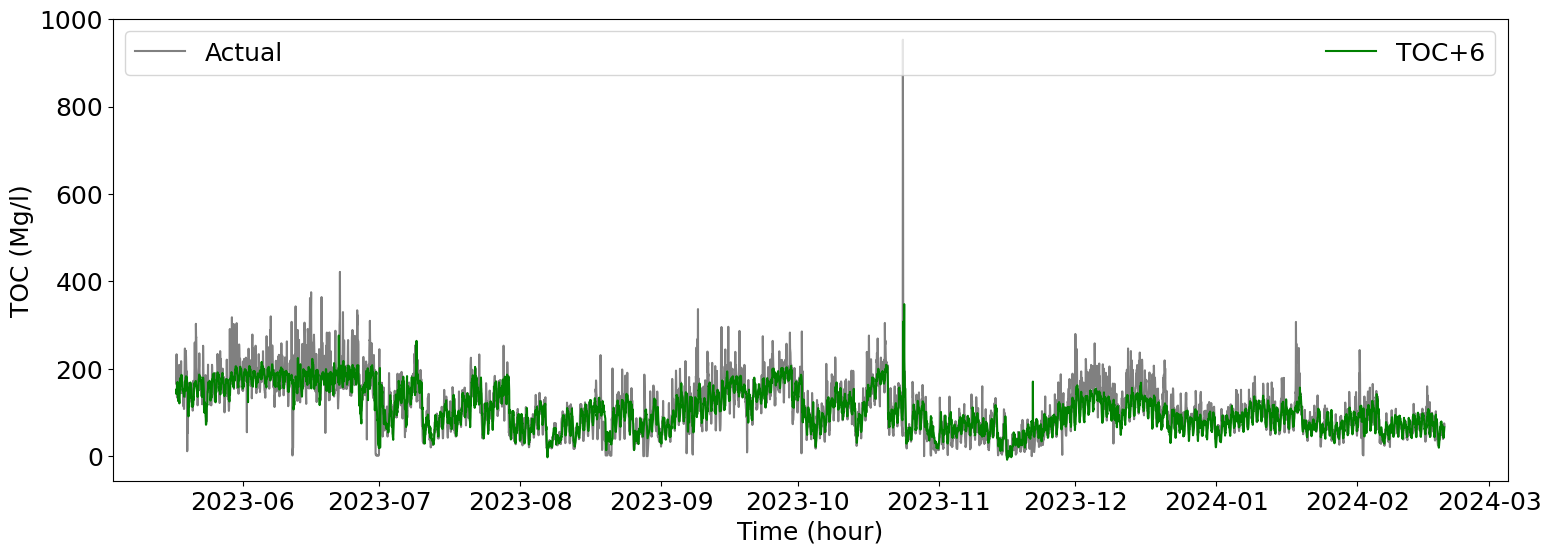

In [64]:
import matplotlib.pyplot as plt

#--------------------------------------------------------------------
#select the feature, and the forcast length to compare:
feature = 'TOC'
forcastlength = 6
#--------------------------------------------------------------------

TS = f'{feature}+{forcastlength}'
#linier graph for Test section
time=y_test.index
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(18,6), )

plt.plot(time,yo[20000:26683][TS], color = 'gray', label = 'Actual')
plt.plot(time,dfxgb_y_pred[TS], color = 'green', label = TS)

plt.xlabel("Time (hour)")
plt.ylabel(f'{feature} (Mg/l)')
plt.legend(loc='upper center', mode='expand',ncol=5)
plt.show()

In [65]:

import plotly.graph_objects as go
import plotly.express as px

fig = px.line(dfxgb_y_pred, x=dfxgb_y_pred.index, y=TS)
fig.add_scatter(x=dfxgb_y_pred.index, y=yo[20000:26683][TS]) # No

# # Show plot 
fig.show()

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fetures = ['TOC','TN','TP','SS']

for feature in fetures:
    for i in range(1,7,1):
        index = f'{feature}+{i}'
        xgb_stat = r2_score(yo[20000:26683][index], dfxgb_y_pred[index]) #Just copy one of the functions in the first line for different comparisions
        print(f'{index}: {xgb_stat}')
    print('--------------------------')

TOC+1: 0.7994009466744308
TOC+2: 0.7089586835261423
TOC+3: 0.6700531484461583
TOC+4: 0.6649995602369574
TOC+5: 0.6412836411412879
TOC+6: 0.6288169962967873
--------------------------
TN+1: 0.896172180111702
TN+2: 0.814537594934308
TN+3: 0.796877321807664
TN+4: 0.7992261680487871
TN+5: 0.7836088561703304
TN+6: 0.7633081985124176
--------------------------
TP+1: 0.6100439308680871
TP+2: 0.43449916435512415
TP+3: 0.29741752436578284
TP+4: 0.2179922146425306
TP+5: 0.187068137567443
TP+6: 0.1404181456446818
--------------------------
SS+1: 0.9186427861012995
SS+2: 0.8620351558889744
SS+3: 0.831896983765908
SS+4: 0.7928864207795218
SS+5: 0.7591399115506638
SS+6: 0.7313881904638995
--------------------------
